# item 1 - Get data

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

%matplotlib inline

import numpy as np
import os, sys
import imageio
import pandas as pd
import matplotlib.pyplot as plt

path_txt = os.path.join('dataset', 'train', 'gt')
path_mask = os.path.join('dataset', 'train', 'mask')

dirs_txt = os.listdir(path_txt)
dirs_mask = os.listdir(path_mask)

data = dict()

for gt in dirs_txt:
    with open(os.path.join(path_txt, gt)) as f:
        lines = f.readlines()
        
        im_name = gt.replace('gt', 'mask').replace('txt', 'png')
        im_open = (imageio.imread(os.path.join(path_mask, im_name)))

        lista = list()
        for l in lines:
            tly, tlx, bry, brx, tipo = l.split(' ')  
            tly, tlx, bry, brx = map(float, [tly, tlx, bry, brx])
            d = dict()
            d['type'] = tipo.strip()
            
            w = brx - tlx
            h = bry - tly
            
            d['width'] = w
            d['height'] = h
            d['bbox_area'] = w*h
            d['form_factor'] = w/h
            
            d['tly'] = round(tly)
            d['tlx'] = round(tlx)
            d['bry'] = round(bry)
            d['brx'] = round(brx)
            
            sub_mask = im_open[d['tly']:d['bry'], d['tlx']:d['brx']]
            mask_area = np.count_nonzero(sub_mask)
            d['mask_area'] = mask_area
            d['filling_ratio'] = mask_area / d['bbox_area']
            
            lista.append(d)
            
        data[gt] = lista
    

A    103
B     14
C     47
D     71
E     38
F    120
Name: type, dtype: int64


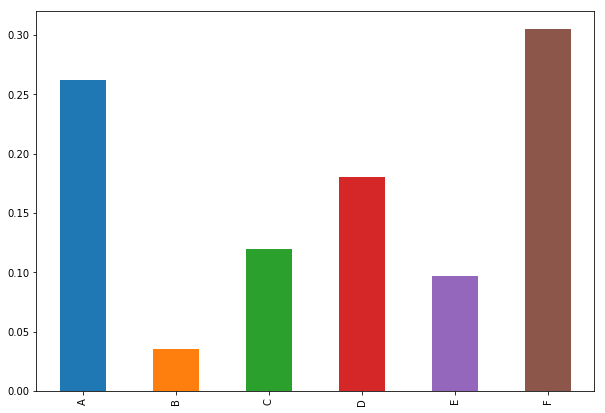

In [57]:
# Write table
columns = ['type','width','height','form_factor','bbox_area','mask_area','filling_ratio']
df = pd.DataFrame.from_dict({(i,n): data[i][n]
                        for i in data.keys()
                        for n,v in enumerate(data[i])}, columns=columns, orient='index').sort_values(['type'])
#print(df)
#df['form_factor'].plot(figsize=(10, 7))

# Count signals
print(df['type'].value_counts(sort=False).reindex(['A','B','C','D','E','F']))
df['type'].value_counts(sort=False,normalize=True).reindex(['A','B','C','D','E','F']).plot(figsize=(10, 7),kind='bar',sort_columns=True)




In [58]:
type_counts = df.groupby('type').aggregate(np.max)
type_counts

#type_counts = df.groupby('type').aggregate(np.median)
#type_counts = df.groupby('type').aggregate(np.average)
#type_counts = df.groupby('type').aggregate(np.std)


,width,height,form_factor,bbox_area,mask_area,filling_ratio
type,,,,,,
A,205.89,179.91,1.227632,37041.6699,18502,0.524561
B,123.23,149.01,1.185969,18362.5023,9164,0.499061
C,235.30,237.65,1.068369,55919.0450,43770,0.786658
D,201.47,183.83,1.095958,37036.2301,31318,0.845604
E,218.90,215.86,1.067998,47251.7540,37035,0.784436
F,273.53,220.53,1.419829,52695.5545,52608,1.008235


In [51]:
# Group data by "type" (letter) and get statistics:

# Function = get_stats (only shape, aspect ratio, etc, NOT COLOUR)

# Queremos estadisticas de tamaño y forma en función de cada letra        

In [ ]:
# Plot and compare results

# Item 2 - Split training dataset

Al separar por tipo, tenemos que armar un algoritmo que nos separe el set de training en dos carpetas, 
separando mismos tipos en 70% / 30%.

# Item 3 - Separation by colour


Para cada imagen de prueba, nos basamos en el diccionario y usamos el bounding box que ya calculamos.

Recortamos la imagen, le calculamos el histograma. Sumamos los histogramas de todas las imágenes y obtenemos la suma total.

Luego hacemos lo mismo y al recortar la roi de cada imagen convertimos la roi de rgb a hsv, calculamos el histograma
y obtenemos la suma de todos los histogramas. 

Con estas cosas deberíamos poder obtener los thresholds a aplicar luego.


Hacer gráficos chetos de los histogramas. Ajustar con multiples gaussianas, calcular promedio, mediana, std, etc.
Compararlos y elegir el mejor.

Luego aplicar las máscaras con los thresholds calculados

In [92]:
# Convert RGB images tu HUE images

# Get stats from HUE images

# Plot and compare

# Select thresholds (RGB y HUE)

# Create masks using previous thresholds



# Obtain R, G, B histograms:

In [4]:
path_jpg = os.path.join('dataset', 'train', 'jpg')
dirs_jpg = os.listdir(path_jpg)

def rgb_histogram(gt_dictionary, path_jpg):

    r_hist = np.zeros(255)
    g_hist = np.zeros(255)
    b_hist = np.zeros(255)

    for gt, values in list(gt_dictionary.items()):
        for v in values:

            jpg_name = gt.replace('gt.', '').replace('txt', 'jpg')
            jpg_roi = imageio.imread(os.path.join(path_jpg, jpg_name))[v['tly']:v['bry'], v['tlx']:v['brx']]

            bins = np.histogram(jpg_roi[:,:,0], bins=255, range=(1,255))[1]
            r_hist += np.histogram(jpg_roi[:,:,0], bins=255, range=(1,255))[0]
            g_hist += np.histogram(jpg_roi[:,:,1], bins=255, range=(1,255))[0]
            b_hist += np.histogram(jpg_roi[:,:,2], bins=255, range=(1,255))[0]
    
    return bins, r_hist, g_hist, b_hist


# Calculate histograms with traffic signal data:

bins, r_hist, g_hist, b_hist = rgb_histogram(data, path_jpg)

# Plot R, G, B histograms:

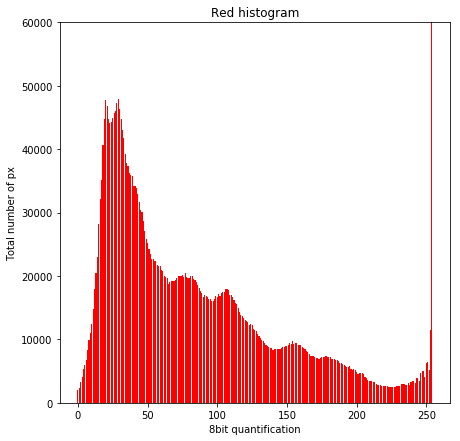

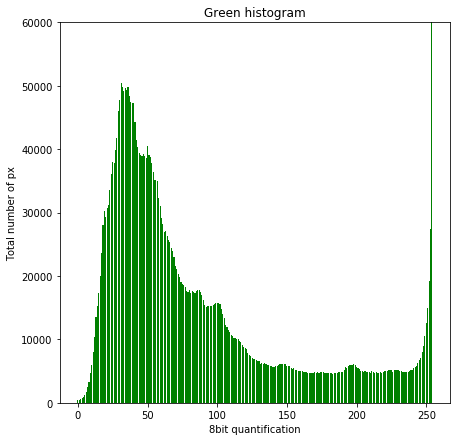

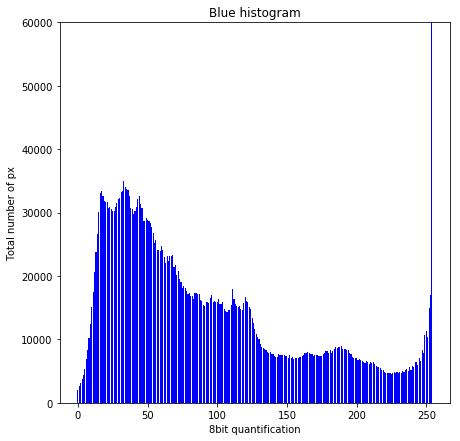

In [23]:
# Questions: why can't I use the variable 'bins' to plot the histograms?
# Why do I get a divergence at 255?

def plot_histogram(hist, color_name, color_plot):

    x = np.arange(255)

    plt.figure(figsize=(7,7))
    plt.bar(x, hist, color=color_plot)
    plt.ylim((0,60000))
    plt.title(color_name + ' histogram')
    plt.xlabel('8bit quantification')
    plt.ylabel('Total number of px')
    plt.show()

plot_histogram(r_hist, 'Red', 'r')
plot_histogram(g_hist, 'Green', 'g')
plot_histogram(b_hist, 'Blue', 'b')


# Item 4 - Evaluate colour masks 

Comparar las máscaras obtenidas con el ground truth.

Podemos ver si sirven las funciones que ya nos dieron hechas.

# Lo que sigue a partir de aqui fueron pruebas hechas el martes:

In [ ]:
print(data['gt.00.005025.txt'][0])
print(data['gt.00.005025.txt'][1])

for gt in dirs_txt:
    print(data[gt][0]['filling_ratio'])

In [ ]:
for mask in dirs_mask:
    gt = mask.replace('mask', 'gt').replace('png', 'txt')
    m = (imageio.imread(os.path.join(path_mask, mask)))
    mask_area = m.sum()
    d = data[gt]
    d['mask_area'] = mask_area
    d['filling_ratio'] = mask_area / d['bbox_area']
    
    print(d['mask_area'], d['filling_ratio'], mask)
    

In [ ]:
print(dirs_mask[0].replace('mask', 'gt').replace('png', 'txt'))
print(dirs_txt[0])


In [ ]:
import matplotlib.pyplot as plt

% matplotlib inline

m = imageio.imread(os.path.join(path_mask,'mask.00.005025.png')).astype(np.int8)

plt.imshow(m[146:201, 1324:1375])
